In [1]:
import sys
import os
import numpy as np
from datetime import date

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

sys.path.insert(1, "../")
from lib.utils import create_data, preproc_pipeline, model_preproc_pipeline, trim_dataset, build_window, moving_test_window_preds
from lib.model import setup_model, train_model

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
os.chdir("../data/Stocks/")

stock = create_data(["aapl.us.txt"])

1  out of  1


In [3]:
stock.head()

,Date,Open,High,Low,Close,Volume,OpenInt,symbol
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,aapl.us.txt
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,aapl.us.txt
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,aapl.us.txt
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,aapl.us.txt
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,aapl.us.txt


In [4]:
# Predicting using opening price
data = stock.iloc[:,1:2]

In [5]:
# Scaling and splitting data
df_train, df_test = preproc_pipeline(data, False)

In [23]:
# Defining hyper parameters
TIME_STEPS = 100
BATCH_SIZE = 128
lr = 0.0001 # learning rate
EPOCHS = 5

In [24]:
# Create windows, trim windows, and reshape for LSTM input
x_train, y_train = model_preproc_pipeline(df_train, TIME_STEPS, BATCH_SIZE)

In [25]:
# Loading model

# load json and create model
# json_file = open('./../saved_models/model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# regressor = model_from_json(loaded_model_json)

# load weights into new model
# regressor.load_weights("./../saved_models/model.h5")
# print("Loaded model from disk")

In [26]:
# Setting up the model
regressor = setup_model(BATCH_SIZE, TIME_STEPS)

In [27]:
# Training the model
regressor = train_model(regressor, x_train, y_train, EPOCHS, BATCH_SIZE, lr)

Epoch 1/3
5700/5700 [==============================] - 242s 42ms/step - loss: 3.4875e-04 - acc: 0.0000e+00
Epoch 2/3
5700/5700 [==============================] - 225s 39ms/step - loss: 3.4743e-05 - acc: 0.0000e+00
Epoch 3/3
5700/5700 [==============================] - 241s 42ms/step - loss: 3.1199e-05 - acc: 0.0000e+00


In [28]:
# serialize model to JSON
model_json = regressor.to_json()
with open("../../saved_models/model" + "aapl" + str(TIME_STEPS) + str(BATCH_SIZE) + str(EPOCHS) + ".json", "w") as json_file:
    json_file.write(model_json)

serialize weights to HDF5
regressor.save_weights("../../saved_models/model" + "aapl" + str(TIME_STEPS) + str(BATCH_SIZE) + str(EPOCHS) + ".h5")
print("Saved model to disk")

Saved model to disk


In [29]:
regressor.evaluate(x_train, y_train)

5700/5700 [==============================] - 89s 16ms/step


[1.535320412234828e-05, 0.0]

In [30]:
# Preparing test and validation sets
df_test = trim_dataset(df_test, BATCH_SIZE)
df_val, df_testing = np.split(df_test, 2)

scale = MinMaxScaler()
scaled_df_val = scale.fit_transform(df_val)

In [31]:
# Reshaping x_val for the LSTM
x_val, y_val = build_window(scaled_df_val, TIME_STEPS)

x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))

In [32]:
# Predicting data using validation data
predicted_stock_price = regressor.predict(x_val)

# Converting back from normalized data
predicted_stock_price = scale.inverse_transform(predicted_stock_price)

<function matplotlib.pyplot.show(*args, **kw)>

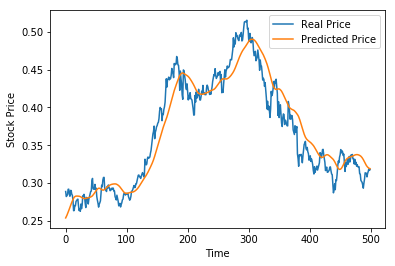

In [33]:
# Plotting results for seen data
plt.figure()
plt.plot(df_val[TIME_STEPS:])
plt.plot(predicted_stock_price)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Real Price', 'Predicted Price'])
plt.show

In [34]:
# Evaluating model for seen data
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df_val[TIME_STEPS:], predicted_stock_price)
mse / (df_val[TIME_STEPS:]).mean()

0.001307891940780262

In [35]:
# evaluating it on seen data
regressor.evaluate(x_val, y_val)

500/500 [==============================] - 8s 17ms/step


[0.0029851073920726776, 0.002]

In [37]:
# Making predictions with unseen data using a moving window
# Making predictions using the last TIME_STEPS df_val value to predict first 500 values of df_testing
unseen_predictions = moving_test_window_preds(df_val, 500, TIME_STEPS, regressor)

<function matplotlib.pyplot.show(*args, **kw)>

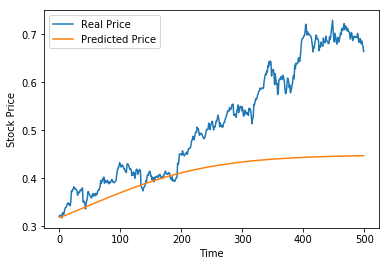

In [38]:
# Plotting results for unseen data
plt.figure()
plt.plot(df_testing[:500])
plt.plot(unseen_predictions)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Real Price', 'Predicted Price'])
plt.show

In [39]:
# Evaluating model for unseen data
mse = mean_squared_error(df_testing[:500], unseen_predictions)
mse / (df_testing[:500]).mean()

0.03732326748276091